In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
import pandas as pd

with open('./muestras/index.json') as f:
    datajson = json.load(f)

In [2]:
def gaussian_entropy(cov_matrix):
    cov_matrix = np.atleast_2d(cov_matrix)
    n = len(cov_matrix)
    det_cov = linalg.det(cov_matrix)
    return 1/2 * np.log2((2*np.pi*np.exp(1))**n * det_cov)

def teoric_TC(cov_matrix):
    n = len(cov_matrix)
    # H(X1,...,Xn)
    H_x = gaussian_entropy(cov_matrix)
    # H(Xi)
    H_xi = [gaussian_entropy(cov_matrix[i, i]) for i in range(n)]
    # sum(H(Xi))
    sum_H_xi = np.sum(H_xi)
    # TC
    TC = sum_H_xi - H_x
    return TC

def teoric_DTC(cov_matrix):
    n = len(cov_matrix)
    # H(X1,...,Xi-1,Xi+1,...,Xn)
    H_xis_ = [gaussian_entropy(np.delete(np.delete(cov_matrix, j, axis=1), j, axis=0)) for j in range(n)] 
    # sum(H(X1,...,Xi-1,Xi+1,...,Xn))
    sum_H_xi_ = np.sum(H_xis_) 
    # H(X1,...,Xn)
    H_x = gaussian_entropy(cov_matrix)
    # (1-n) * H(X1,...,Xn)
    prod_H_x = (1-n) * H_x
    # DTC
    DTC = prod_H_x + sum_H_xi_
    return DTC

def teoric_oinfo(cov_matrix):
    oinfo = teoric_TC(cov_matrix) - teoric_DTC(cov_matrix)
    return oinfo

In [3]:
datajson['gaussian_1']['cov']

[[0.9486545337793236, 0.8898027211921073, 0.6100372359467587],
 [0.8898027211921073, 0.8713281325959036, 0.5399206528673799],
 [0.6100372359467587, 0.5399206528673799, 0.4206449508316386]]

# Matrices empiricas

In [4]:
folders = [f'gaussian_{i}' for i in range(1,10)]
size = [100, 1000, 10000,100000, 1000000]
gaussians = []
gaussiansJson = {}
for i,folder in enumerate(folders):
    original = np.array(datajson[folder]['cov'])
    #length = len(original)
    TCs = []
    DTCs = []
    Oinfos =[]
    for j in range(1,101):
        data = np.load('./muestras/'+folder+f'/samples{j}.npy')
        sample_TCs =[]
        sample_DTCs =[]
        sample_Oinfos =[]
        for n_samples in size:        
            samples = data[:n_samples]        
            empiric_cov = np.cov(samples.T)
            TC = teoric_TC(empiric_cov)
            DTC = teoric_DTC(empiric_cov)
            Oinfo = TC - DTC
            sample_TCs.append(TC)
            sample_DTCs.append(DTC)
            sample_Oinfos.append(Oinfo)        
        TCs.append(np.expand_dims(sample_TCs, axis=0))        
        DTCs.append(np.expand_dims(sample_DTCs, axis=0))
        Oinfos.append(np.expand_dims(sample_Oinfos, axis=0))
    np_TCs = np.concatenate(TCs, axis=0)    
    np_DTCs = np.concatenate(DTCs, axis=0)
    np_Oinfos = np.concatenate(Oinfos, axis=0)
    mean_TCs = np.mean(np_TCs, axis=0)
    print(mean_TCs)
    mean_DTCs = np.mean(np_DTCs, axis=0)
    mean_Oinfos= np.mean(np_Oinfos, axis=0)
    std_TCs = np.std(np_TCs, axis=0)
    std_DTCs = np.std(np_DTCs, axis=0)
    std_Oinfos = np.std(np_Oinfos, axis=0)
    gaussians.append({
        "mean_TCs":mean_TCs,
        "mean_DTCs":mean_DTCs,
        "mean_Oinfos":mean_Oinfos,
        "std_TCs":std_TCs,
        "std_DTCs":std_DTCs,
        "std_Oinfos":std_Oinfos,
    })
    gaussiansJson[f"gaussian_{i+1}"]={
        "mean_TCs":mean_TCs.tolist(),
        "mean_DTCs":mean_DTCs.tolist(),
        "mean_Oinfos":mean_Oinfos.tolist(),
        "std_TCs":std_TCs.tolist(),
        "std_DTCs":std_DTCs.tolist(),
        "std_Oinfos":std_Oinfos.tolist(),
    }

[14.99655742 14.94223289 14.94031023 14.94255477 14.94296362]
[6.60659089 6.55184739 6.55066185 6.55322268 6.55358716]
[2.08038324 2.03797748 2.03650372 2.03855865 2.0388774 ]
[10.73292248 10.67165237 10.67183336 10.67017676 10.6705835 ]
[8.46780475 8.39272324 8.39467055 8.39430102 8.39496055]
[5.34007842 5.25946542 5.26224629 5.2621757  5.26297241]
[17.44308429 17.19663546 17.15900919 17.16378573 17.15895974]
[12.66836009 12.41722174 12.3779561  12.38254993 12.37773045]
[13.17640718 12.92115712 12.88315101 12.88655592 12.88169924]


In [5]:
with open("./metrics.json", "w") as f:
        json.dump(gaussiansJson, f)

In [6]:
gaussians
df = pd.DataFrame(gaussians)
df[["mean_TCs"]]

,mean_TCs
0,"[14.996557423374407, 14.942232887910581, 14.94..."
1,"[6.606590887946773, 6.5518473867807, 6.5506618..."
2,"[2.08038323958126, 2.0379774788063747, 2.03650..."
3,"[10.732922481014402, 10.671652369204377, 10.67..."
4,"[8.467804750481582, 8.392723242388369, 8.39467..."
5,"[5.3400784224235744, 5.2594654210668565, 5.262..."
6,"[17.443084294202727, 17.196635456192435, 17.15..."
7,"[12.668360086258962, 12.417221744276663, 12.37..."
8,"[13.176407182266171, 12.921157124409847, 12.88..."


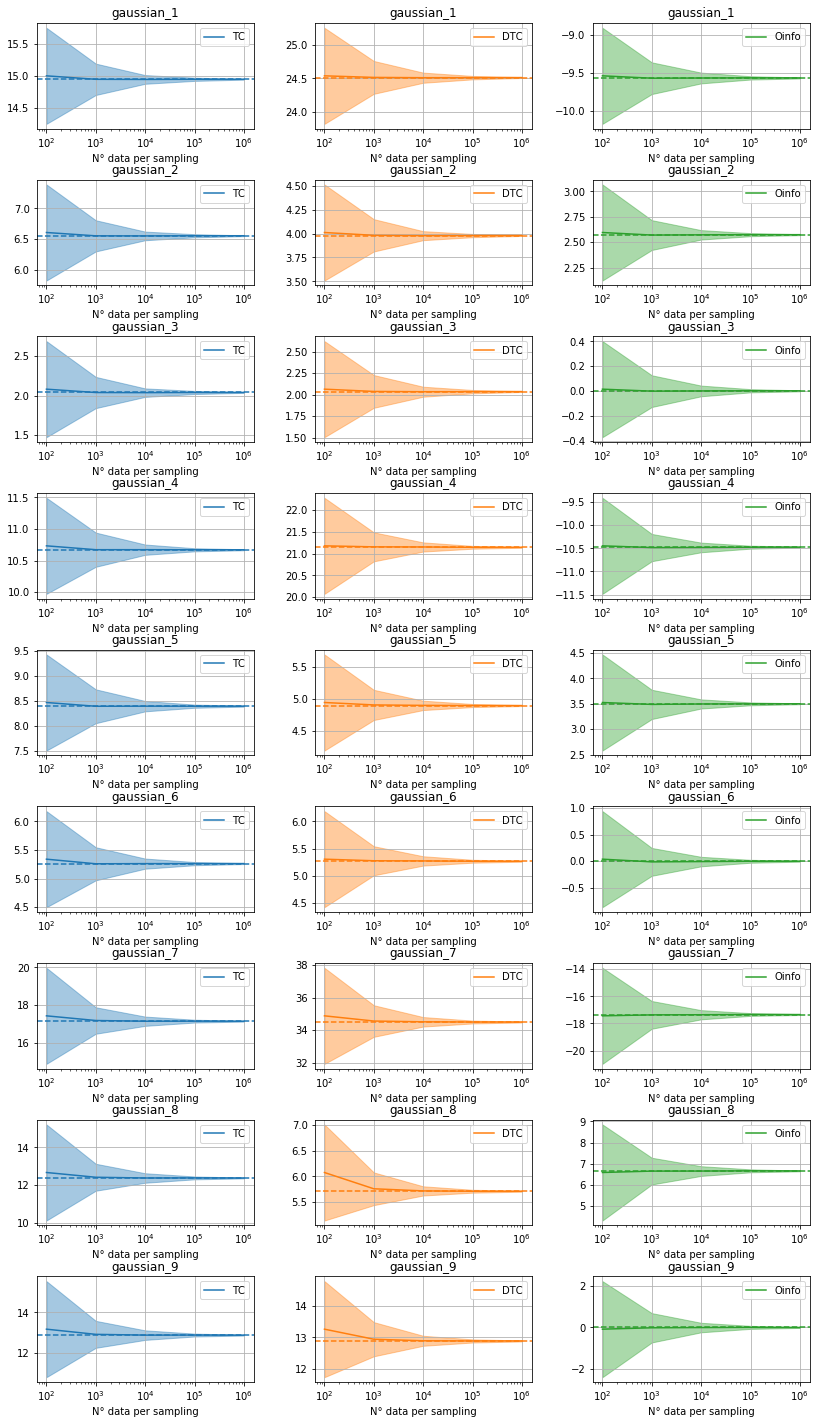

In [7]:
fig, axs = plt.subplots(len(folders), 3, figsize=(12,20))
#fig.set_size_inches(5,20)
fig.tight_layout(pad=3.0)
for i,folder in enumerate(folders):
    gaussian = gaussians[i]
    axs[i, 0].plot(size,gaussian['mean_TCs'], label='TC', color="C0")
    axs[i, 1].plot(size,gaussian['mean_DTCs'], label='DTC', color="C1")
    axs[i, 2].plot(size,gaussian['mean_Oinfos'], color="C2", label='Oinfo')
    axs[i, 0].axhline(datajson[f"gaussian_{i+1}"]['TC'], linestyle="--", color="C0")
    axs[i, 1].axhline(datajson[f"gaussian_{i+1}"]['DTC'], linestyle="--", color="C1")
    axs[i, 2].axhline(datajson[f"gaussian_{i+1}"]['O'], linestyle="--", color="C2")
    axs[i, 0].fill_between(size, gaussian['mean_TCs']-3*gaussian['std_TCs'], gaussian['mean_TCs']+3*gaussian['std_TCs'], alpha=0.4, color="C0")
    axs[i, 1].fill_between(size, gaussian['mean_DTCs']-3*gaussian['std_DTCs'], gaussian['mean_DTCs']+3*gaussian['std_DTCs'], alpha=0.4, color="C1")
    axs[i, 2].fill_between(size, gaussian['mean_Oinfos']-3*gaussian['std_Oinfos'], gaussian['mean_Oinfos']+3*gaussian['std_Oinfos'], alpha=0.4, color="C2")
    axs[i, 0].set_title(folder)
    axs[i, 1].set_title(folder)
    axs[i, 2].set_title(folder)
    axs[i, 0].set_xlabel('N° data per sampling')
    axs[i, 1].set_xlabel('N° data per sampling')
    axs[i, 2].set_xlabel('N° data per sampling')
    axs[i, 0].set_xscale('log')
    axs[i, 1].set_xscale('log')
    axs[i, 2].set_xscale('log')
    axs[i, 0].grid()
    axs[i, 1].grid()
    axs[i, 2].grid()
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 2].legend()
fig.savefig('cov_metrics_validation.pdf')
fig.savefig('cov_metrics_validation.png')

In [8]:
datajson

{'gaussian_1': {'cov': [[0.9486545337793236,
    0.8898027211921073,
    0.6100372359467587],
   [0.8898027211921073, 0.8713281325959036, 0.5399206528673799],
   [0.6100372359467587, 0.5399206528673799, 0.4206449508316386]],
  'TC': 14.94294800076612,
  'DTC': 24.511912840313215,
  'O': -9.568964839547094,
  'TC_list': [2.284166784638799, 12.658781216127322],
  'DTC_list': [12.658781216127322, 11.853131624185892]},
 'gaussian_2': {'cov': [[1.7820428291000843,
    2.0761737700739205,
    1.8630084127252586],
   [2.0761737700739205, 2.45134450246227, 2.20499211418001],
   [1.8630084127252586, 2.20499211418001, 2.0013729474860438]],
  'TC': 6.553575100639658,
  'DTC': 3.9794005557070427,
  'O': 2.574174544932615,
  'TC_list': [3.118657082641791, 3.434918017997867],
  'DTC_list': [3.434918017997867, 0.5444825377091758]},
 'gaussian_3': {'cov': [[1.4047522276240016,
    0.7133489283801965,
    1.3754991844892672],
   [0.7133489283801965, 1.1990381936177523, 1.2639095070810848],
   [1.375499

# Rango de matrices originales

In [9]:
for folder in folders:
    cov = np.array(datajson[folder]['cov'])
    print(np.linalg.matrix_rank(cov))

3
3
3
4
4
4
10
10
10


In [10]:
metric_plot = "TC"
i = 0
for gaussian_i in sorted(os.listdir(results_folder)):
    if i % 3 == 0:
        i = 0
        fig, ax = plt.subplots(figsize=(10,5))
    mean = pd.DataFrame(gaussian_results[gaussian_i]["mean"], columns=["TC", "DTC", "O"], index=[100, 1000, 10000, 100000])
    std = pd.DataFrame(gaussian_results[gaussian_i]["std"], columns=["TC", "DTC", "O"], index=[100, 1000, 10000, 100000])
    mean = mean.rename(columns={metric_plot: gaussian_i})
    mean[[gaussian_i]].plot(ax=ax)
    ax.fill_between(mean.index, mean[gaussian_i]-3*std[metric_plot], mean[gaussian_i]+3*std[metric_plot], alpha=0.2)
    ax.axhline(y=index[gaussian_i][metric_plot], color=f"C{i}", linestyle='--')
    ax.set_xscale('log')
    ax.set_title(metric_plot)
    plt.xlim(10*2, 10*5)
    plt.grid(axis="x")
    i += 1

NameError: name 'os' is not defined

In [ ]:
for i in range(1,101):
    print(i)